* A pipeline to which you feed an mri image and
 spits out muscle predictions and lever arms.

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8
from mri_project.custom_imports import *
import mri_project.muscle_detector as md
import mri_project.contour_ops as cntop
from mri_project import pipeline
import mri_project.utility as ut
from mri_project.notebooks import n2021_01_30_connor_lever_arms as nb

In [5]:
ls /home/bzr0014/git/idea_mri_project/data/old/connor_images/

 bar_train.zip  'CONTROL W SURVEY'/   INTERVENTION/  'TAI CHI'/


In [11]:
root = "/home/bzr0014/git/idea_mri_project/data/old"
connor_images_root = f"{root}/connor_images/"
files = ut.get_all_images(connor_images_root, extension='jpg')
files = [x for x in files if 'CO12' in x]

In [12]:
# file = "/home/bzr0014/git/idea_mri_project/data/connor_images/INTERVENTION/CO7B/4-CO7B-14BEH.jpg"
for file in files:
    imgs = nb.compute_lever_arms_for_trace_file(file, angles=(45, 90, 135, 180))
    nb.save_img_dict(imgs, ut.replace_path(file, connor_images_root, "../data/connor_lever_arms"))

/home/bzr0014/git/idea_mri_project/data/old/connor_images/CONTROL W SURVEY/CO12B/4-CO12B-14BEH.jpg
(1553, 1568, 3)
/home/bzr0014/git/idea_mri_project/data/connor_lever_arms/CONTROL W SURVEY/CO12B/4-CO12B-14BEH_45.jpg
/home/bzr0014/git/idea_mri_project/data/connor_lever_arms/CONTROL W SURVEY/CO12B/4-CO12B-14BEH_90.jpg
/home/bzr0014/git/idea_mri_project/data/connor_lever_arms/CONTROL W SURVEY/CO12B/4-CO12B-14BEH_135.jpg
/home/bzr0014/git/idea_mri_project/data/connor_lever_arms/CONTROL W SURVEY/CO12B/4-CO12B-14BEH_180.jpg
/home/bzr0014/git/idea_mri_project/data/old/connor_images/CONTROL W SURVEY/CO12B/1-CO12B-3BEH.jpg
(1553, 1568, 3)
/home/bzr0014/git/idea_mri_project/data/connor_lever_arms/CONTROL W SURVEY/CO12B/1-CO12B-3BEH_45.jpg
/home/bzr0014/git/idea_mri_project/data/connor_lever_arms/CONTROL W SURVEY/CO12B/1-CO12B-3BEH_90.jpg
/home/bzr0014/git/idea_mri_project/data/connor_lever_arms/CONTROL W SURVEY/CO12B/1-CO12B-3BEH_135.jpg
/home/bzr0014/git/idea_mri_project/data/connor_lever_arms

# Appendix

## The process

/home/bzr0014/git/idea_mri_project/data/old/connor_images/CONTROL W SURVEY/CO12B/2-CO12B-6BEH.jpg


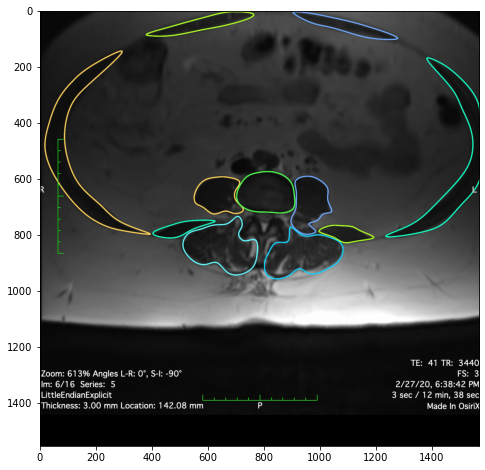

(1553, 1568, 3)


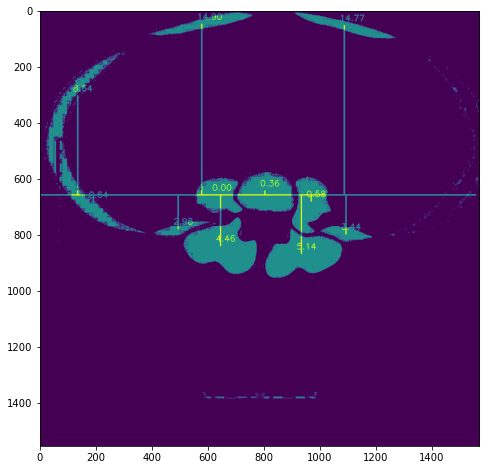

In [47]:
deg = 180
file = np.random.choice(files)
file = "/home/bzr0014/git/idea_mri_project/data/old/connor_images/CONTROL W SURVEY/CO12B/2-CO12B-6BEH.jpg"
# file = "/home/bzr0014/git/idea_mri_project/data/connor_images/TAI CHI/TC7B/3-TC7B-11BEH.jpg"
print(file)
img = md.read_image(file)
plt.imshow(img)
plt.show()
t = md.MuscleDetector(file, file, traced_image=file)
t.get_traced_binary_mask()
t.get_traced_contours(deg)
plt.imshow(t.traced_lever_arm_images[deg])

In [58]:
img.shape

(1553, 1568, 3)

In [59]:
a, b = np.where(ut.get_muscles(img))

In [63]:
np.sum(a == 0), np.sum(b == img.shape[1]-1)

(122, 91)

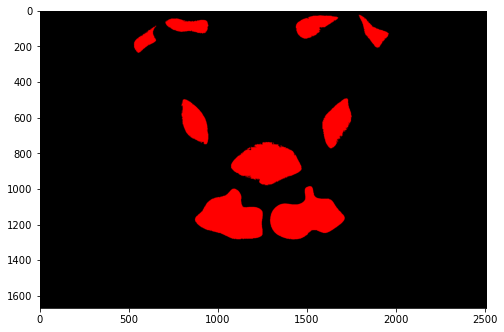

In [21]:
imt = np.zeros_like(t.traced_image)
plt.imshow(cv2.drawContours(imt, list(t.traced_contours.values()), -1, 255, -1))

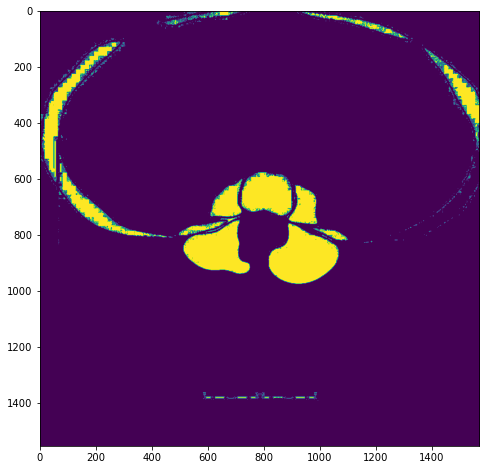

In [17]:
floodfill = ut.get_muscles(t.traced_image)
plt.imshow(floodfill)

In [214]:
np.unique(floodfill)

array([0, 1], dtype=uint8)

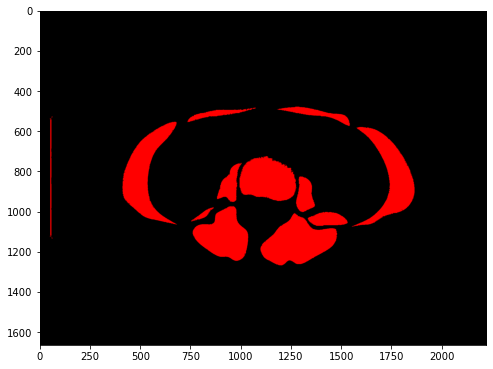

In [215]:
cnt_dict = ut.get_muscle_contours_dict(floodfill, True)
cnts = [v[0] for k, v in cnt_dict.items() if k != 0]
imt = np.zeros_like(t.traced_image)
plt.imshow(cv2.drawContours(imt, cnts, -1, 255, -1))

## Training the clustering model

In [21]:
model = md.train_clustering_model_on_dir("../data/bar_train/*")

In [27]:
img = cv2.imread(np.random.choice(files), 0)
thresh = md.get_thresh(img, model)
_, cnts, _ = cntop.find_contours(thresh)
cnts = [cnt for cnt in cnts if len(cnt) > 50]
idx = np.argsort([cntop.elongation(cnt) for cnt in cnts])[::-1]
picked_cnts = [cnts[i] for i in idx[:1]]
mx = picked_cnts[0].max(axis=(0, 1))
mn = picked_cnts[0].min(axis=(0, 1))
length = np.max(mx - mn)
scale = 10 / length
scale

0.017271157167530225

In [562]:
joblib.dump(model, models_dir+"scale_bar_clustering_model.pkl")

['/home/bzr0014/git/idea_mri_project/mri_project/resources/models/scale_bar_clustering_model.pkl']